<h1>코로나-19 확진자 예측(facebook prophet 이용)</h1>

<h2>라이브러리</h2>

In [8]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
#interactive한 그래프 만들어 줌 
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot


<h2>데이터셋 불러오기</h2>

In [10]:
df=pd.read_csv('datasets_524794_963213_time_series_19-covid-Confirmed.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20
0,Anhui,Mainland China,31.82571,117.2264,1,9,15,39,60,70,...,889,910,934,950,962,973,982,986,987,988
1,Beijing,Mainland China,40.18238,116.4142,14,22,36,41,68,80,...,352,366,372,375,380,381,387,393,395,396
2,Chongqing,Mainland China,30.05718,107.8740,6,9,27,57,75,110,...,518,529,537,544,551,553,555,560,567,572
3,Fujian,Mainland China,26.07783,117.9895,1,5,10,18,35,59,...,272,279,281,285,287,290,292,293,293,293
4,Gansu,Mainland China,36.06110,103.8343,0,2,2,4,7,14,...,87,90,90,90,90,91,91,91,91,91


<h2> Filter 적용 </h2>

In [42]:
df_korea = df[df['Country/Region']=='South Korea']
df_korea.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20
33,NaN,South Korea,37.5665,126.978,1,1,2,2,3,4,...,28,28,28,28,29,30,31,31,104,204


<h2> 간단하게 만들기 </h2>

In [43]:
df_korea=df_korea.T[4:]#Transpose(필요한 열만 뽑아옴)
df_korea.head()
df_korea=df_korea.reset_index().rename(columns={'index':'date',33:'confirmed'})
#column 명 바꿔주기

print(df_korea.head())
print("\n")

df_korea['date']=pd.to_datetime(df_korea['date'])
#type datetime으로 바꿔주기


df_korea.head()

      date confirmed
0  1/22/20         1
1  1/23/20         1
2  1/24/20         2
3  1/25/20         2
4  1/26/20         3




,date,confirmed
0,2020-01-22,1
1,2020-01-23,1
2,2020-01-24,2
3,2020-01-25,2
4,2020-01-26,3


<h2>최근 데이터 추가해주기</h2>

In [96]:
df_korea=df_korea.append([{'date': pd.to_datetime('2020-02-22'),'confirmed':433},
                         {'date' : pd.to_datetime('2020-02-23'),'confirmed':568}],ignore_index=True)

#ignore index true로 해줘야 오류 안남
df_korea.tail()

,date,confirmed
34,2020-02-23,690
35,2020-02-22,433
36,2020-02-23,690
37,2020-02-22,433
38,2020-02-23,568


In [97]:
fig =go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_korea.date,
        y=df_korea.confirmed,
        name='Confirmed in Korea'
    )
)

 

 <h2>Facebook Prophet 사용하기</h2>

In [98]:
df_prophet=df_korea.rename(columns={
    'date':'ds',
    'confirmed':'y'
})
df_prophet.head()

,ds,y
0,2020-01-22,1
1,2020-01-23,1
2,2020-01-24,2
3,2020-01-25,2
4,2020-01-26,3


<h2>Model 만들기</h2>

In [106]:
m = Prophet(
    changepoint_prior_scale=0.8,#커질수록 모델이 유연하게 바뀜
    changepoint_range=0.98,#데이터 앞쪽  몇 퍼센트 부분안에서 변화점을 만들 것인지 설정
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
    seasonality_mode = 'additive')# 데이터셋이 적으므로 year ,weakly는 빼준다
# 합산형태일 떄 additive, 곱해지는 형태면 multiplicative 사용

In [107]:
m.fit(df_prophet)# data fitting
future = m.make_future_dataframe(periods=7)
# 앞으로 예측할 공간 만들어주기

In [108]:
future.tail(7)

,ds
39,2020-02-24
40,2020-02-25
41,2020-02-26
42,2020-02-27
43,2020-02-28
44,2020-02-29
45,2020-03-01


<h2> Predict</h2>

In [109]:
forecast =m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(7)

#ds 날짜
#yhat 예측값
#yhat_lower 오차를 고려한 예측 최소값
#yhat_upper 오차를 고려한 예측 최대값

,ds,yhat,yhat_lower,yhat_upper
39,2020-02-24,883.251016,859.422616,907.212135
40,2020-02-25,1108.749540,1078.197144,1138.456447
41,2020-02-26,1334.248064,1291.356086,1378.864279
42,2020-02-27,1559.746588,1494.149862,1624.962753
43,2020-02-28,1785.245112,1694.533385,1876.816672
44,2020-02-29,2010.743637,1891.755334,2128.963344
45,2020-03-01,2236.242161,2086.511757,2386.543365


<h2>Plot Prediction</h2>

In [110]:
fig =plot_plotly(m,forecast)

In [111]:
py.iplot(fig)

<h2>plot changepoint</h2>

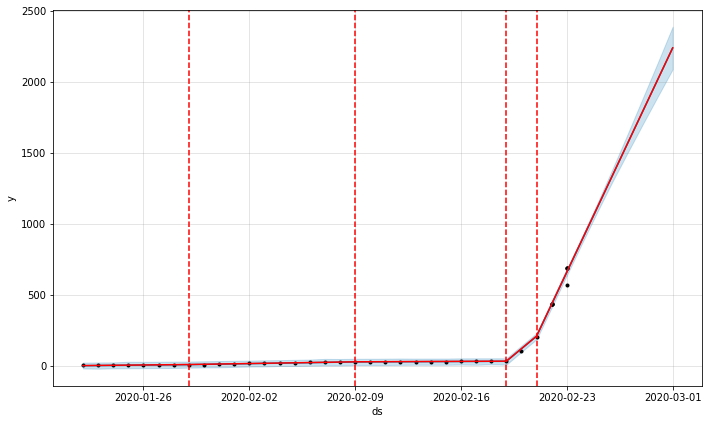

In [112]:
fig =m.plot(forecast)
a= add_changepoints_to_plot(fig.gca(),m,forecast)